In [1]:
import os
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import transforms, utils
from torch.utils.data import DataLoader, TensorDataset

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2


from datasets_local import gaussian_mixture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


In [2]:

from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
vocab_size = 2
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (1, 28, 28)
num_timesteps = 100

p_ref = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
p_ref.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))
p_ref.eval()

MaskedDiffusion(
  (denoising_model): UNetWithAttention(
    (embedding): Embedding(3, 64)
    (time_embedding): SinusoidalPosEmb()
    (temb_mlp): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): NonLinearity()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NonLinearity()
    )
    (initial_block): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): ResNetBlock(
          (norm1): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin1): NonLinearity()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin2): NonLinearity()
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), str

In [ ]:
# Visualize samples from the pretrained model
with torch.no_grad():
    samples = p_ref.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [3]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch
mnist_classfier_model = BinarizedMNISTClassifier().to(device)
mnist_classfier_model.load_state_dict(torch.load('../model_weights/binarized_mnist_classifier_1.pth'))

def compute_rewards_for_batch(x: Tensor, with_grad=False):
    # x.shape : (B, 1, 28, 28, num_categories)
    logits = mnist_classfier_model(x[..., :vocab_size].to(device)) # Shape: (B, 10)
    logits = logits.log_softmax(dim=-1) # Shape: (B, 10)
    reward = logits[:, 4]
    return reward

def compute_rewards(x, with_grad=False):
    n_samples = x.shape[0]
    rewards_all = []
    for i in range(0, n_samples, batch_size):
        if with_grad:
            rewards = compute_rewards_for_batch(x[i:i + batch_size])
        else:
            with torch.no_grad():
                rewards = compute_rewards_for_batch(x[i:i + batch_size])
        rewards_all.append(rewards)
    rewards_all = torch.cat(rewards_all)
    return rewards_all

kl_weight = 1.0

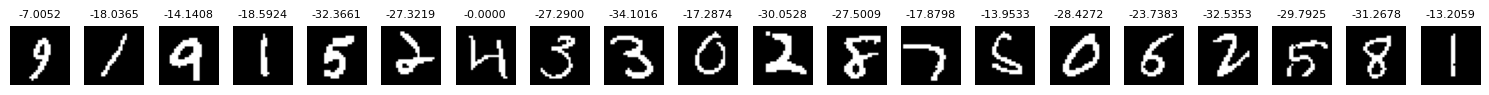

In [4]:
# Visualize rewards
from datasets_local.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=20)
samples, _ = next(iter(train_loader))
rewards = compute_rewards(F.one_hot(samples.long(), num_classes=num_categories).float())

fig, axes = plt.subplots(1, 20, figsize=(15, 2))
for i in range(20):
    ax = axes[i]
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.set_title(f"{rewards[i].item():.4f}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

Visualize target dist

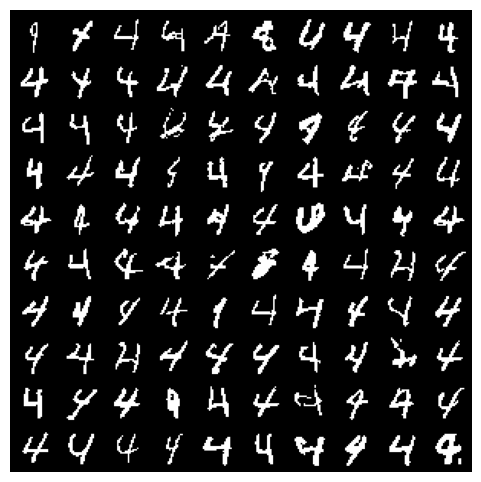

Target Reward: -0.11017806082963943
Diversity: 95


In [4]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    dataset = torch.load("../datasets_local/pretrained_mnist_samples_dataset.pt", weights_only=False)
    train_loader = DataLoader(dataset, batch_size)
    log_pdf_values = []
    for samples, _ in train_loader:
        samples = samples.long()
        log_pdf_values.append(target_distribution_log_pdf(samples, kl_weight))
    log_pdf_values = torch.cat(log_pdf_values, dim=0)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return torch.stack([train_loader.dataset[i][0].long() for i in indices])

target_samples = sample_target_distribution(100, kl_weight)

grid = utils.make_grid(target_samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().float().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

target_rewards = compute_rewards(
    F.one_hot(target_samples, num_classes=num_categories).float()
)
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {torch.unique(target_samples, dim=0).shape[0]}")

Divergence logic

In [5]:
def calculate_loss(
    r : torch.Tensor,
    tilde_r: torch.Tensor,
    f_divergence: str = "forward-KL",
    alpha: Optional[float] = None,
    softmax_dim=-1,
) -> torch.Tensor:
    log_w = F.log_softmax(r, dim=softmax_dim)
    log_tilde_w = F.log_softmax(tilde_r, dim=softmax_dim)
    w = log_w.exp()
    tilde_w = log_tilde_w.clamp_min(-100).exp()
    if f_divergence == "forward-KL":
        loss = w * (log_w - log_tilde_w)
    elif f_divergence == "reverse-KL":
        loss = tilde_w * (log_tilde_w - log_w)
    elif f_divergence == "jeffrey":
        loss = (w - tilde_w) * (log_w - log_tilde_w)
    elif f_divergence == "square-hellinger":
        loss = (w.sqrt() - tilde_w.sqrt()) ** 2
    elif f_divergence == "jensen-shannon":
        loss = 0.5 * (
            w * (torch.log(2 * w) - torch.log(w + tilde_w)) +
            tilde_w * (torch.log(2 * tilde_w) - torch.log(w + tilde_w))
        )
    elif f_divergence == "alpha-divergence":
        assert alpha is not None, "Value of alpha should be provided for alpha-divergence."
        # loss_og = (1 / (alpha * (alpha - 1))) * (
        #     tilde_w * ((w / tilde_w) ** (1 - alpha) - (1 - alpha) * (w / tilde_w) - alpha)
        # )
        # Equivalent loss formula without division by zero problem of the original formula
        loss = (1 / (alpha * (alpha - 1))) * (
            (w ** (1 - alpha)) * (tilde_w ** alpha) - (1 - alpha) * w - alpha * tilde_w
        )
    else:
        raise ValueError(f"{f_divergence} is not supported.")
    return loss

In [6]:
q_phi = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
q_phi.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))
q_phi.eval()

MaskedDiffusion(
  (denoising_model): UNetWithAttention(
    (embedding): Embedding(3, 64)
    (time_embedding): SinusoidalPosEmb()
    (temb_mlp): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): NonLinearity()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NonLinearity()
    )
    (initial_block): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): ResNetBlock(
          (norm1): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin1): NonLinearity()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin2): NonLinearity()
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), str

In [ ]:
batch_size = 32
lr = 0.01
optimizer = torch.optim.Adam(q_phi.parameters(), lr=lr)
num_epochs = 100
batches_per_epoch = 100
patience = 5
f_divergence = "forward-KL"
alpha = 0.8
timesteps_for_loss = 10
randomly_select_timesteps_for_loss = True

os.makedirs('../model_weights/importance_weighted_loss/binarized_mnist', exist_ok=True)
ckpt_path = f'../model_weights/importance_weighted_loss/binarized_mnist/{f_divergence}.pth'
if f_divergence == "alpha-divergence":
    ckpt_path = f'../model_weights/importance_weighted_loss/binarized_mnist/{f_divergence}_{alpha}.pth'

In [8]:
loss_trace = []
reward_trace = []

In [ ]:
L = math.prod(q_phi.input_shape)

# Training loop
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    for batch_idx in tqdm(range(batches_per_epoch)):
        q_phi.train()
        
        q_phi_z0_given_zt_list = torch.zeros(batch_size, timesteps_for_loss, L, q_phi.num_categories, device=device)
        p_ref_z0_given_zt_list = torch.zeros(batch_size, timesteps_for_loss, L, q_phi.num_categories, device=device)
        
        q_phi_log_joint_probs = torch.zeros(batch_size, device=device)
        p_ref_log_joint_probs = torch.zeros(batch_size, device=device)
        
        beta_ts = torch.zeros(timesteps_for_loss, device=device)
        
        # Sample timesteps_for_loss random steps
        if randomly_select_timesteps_for_loss:
            is_selected_timestep = torch.zeros(
                q_phi.num_timesteps, dtype=torch.bool
            ).scatter_(0, torch.randperm(q_phi.num_timesteps)[:timesteps_for_loss], True)
        else:
            is_selected_timestep = torch.zeros(
                q_phi.num_timesteps, dtype=torch.bool
            )
            is_selected_timestep[:timesteps_for_loss] = True
        list_idx = 0
        
        # Generate batch_size samples from q_phi
        z_t = torch.full((batch_size, L), q_phi.mask_index, device=device) # Intialize with all masks
        for i in range(q_phi.num_timesteps, 0, -1):
            q_phi_zs_given_zt, q_phi_z0_given_zt = q_phi.sample_step(
                F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
            )
            if is_selected_timestep[i - 1]:
                q_phi_z0_given_zt_list[:, list_idx] = q_phi_z0_given_zt
            with torch.no_grad():
                p_ref_zs_given_zt, p_ref_z0_given_zt = p_ref.sample_step(
                    F.one_hot(z_t, num_classes=q_phi.num_categories).float(), i, device
                )
            if is_selected_timestep[i - 1]:
                p_ref_z0_given_zt_list[:, list_idx] = p_ref_z0_given_zt
            
            # Also save beta_t
            if is_selected_timestep[i - 1]:
                t = p_ref.discrete_time_scheduler.discrete_time(i).to(device)
                alpha_t = p_ref.scheduler.alpha(t)
                beta_t = kl_weight / (1 - alpha_t)
                beta_ts[list_idx] = beta_t
            
            # Create distributions
            q_phi_zs_given_zt_dist = torch.distributions.Categorical(probs=q_phi_zs_given_zt)
            p_ref_zs_given_zt_dist = torch.distributions.Categorical(probs=p_ref_zs_given_zt)
            
            # Sample z_s from q_phi's dist
            z_s = q_phi_zs_given_zt_dist.sample()
            
            # Update joint probs (detach to cut gradient flow to joint probabilities, used for importance weights)
            q_phi_log_joint_probs += q_phi_zs_given_zt_dist.log_prob(z_s).sum(dim=1).detach()
            p_ref_log_joint_probs += p_ref_zs_given_zt_dist.log_prob(z_s).sum(dim=1).detach()
            
            # Update z_t for next loop
            z_t = z_s
            if is_selected_timestep[i - 1]:
                list_idx += 1
            
        assert list_idx == timesteps_for_loss
            
        z0_samples = z_t.reshape(batch_size, *q_phi.input_shape)
        # Sanity check - the final sample should not have any masked tokens
        assert torch.all(z0_samples != q_phi.mask_index)
        
        # Calculate r
        with torch.no_grad():
            r = compute_rewards(F.one_hot(z0_samples, num_classes=num_categories).float()) # Shape (batch_size,)
            r = r.unsqueeze(1).expand(batch_size, timesteps_for_loss)
            
        # Calculate r_tilde
        q_phi_z0_given_zt_dist = torch.distributions.Categorical(probs=q_phi_z0_given_zt_list)
        p_ref_z0_given_zt_dist = torch.distributions.Categorical(probs=p_ref_z0_given_zt_list)
        tilde_r = beta_ts * (
            q_phi_z0_given_zt_dist.log_prob(
                z0_samples.reshape(batch_size, L).unsqueeze(1).expand(batch_size, timesteps_for_loss, L)
            ).sum(dim=-1) -
            p_ref_z0_given_zt_dist.log_prob(
                z0_samples.reshape(batch_size, L).unsqueeze(1).expand(batch_size, timesteps_for_loss, L)
            ).sum(dim=-1)
        ) # Shape (batch_size, steps_for_loss)
        
        # softmax is on the batch dimension
        loss = calculate_loss(r, tilde_r, f_divergence=f_divergence, alpha=alpha, softmax_dim=0) # Shape (batch_size, steps_for_loss)
        loss = loss.mean(dim=1)  # Average over timesteps # Shape (batch_size, )
        
        # calculate importance weights
        importance_weights = torch.exp(torch.log_softmax(p_ref_log_joint_probs - q_phi_log_joint_probs, dim=0))  # Shape (batch_size, )
        print("Importance weights: ", importance_weights)
        loss = (importance_weights * loss).sum(dim=0)
        loss = loss / importance_weights.sum()  # Normalize by the sum of importance weights
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
        print(f"Batch idx: {batch_idx}, Loss: {loss.item()}")
    
    q_phi.eval()
    avg_loss = total_epoch_loss / batches_per_epoch
    print(f"Epoch {epoch+1}/{num_epochs},  Loss: {avg_loss}")
    loss_trace.append(avg_loss)
    
    with torch.no_grad():
        model_samples = q_phi.sample(num_samples=100, device=device).cpu()
    grid = utils.make_grid(model_samples.float(), nrow=10, padding=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
    plt.axis('off')
    plt.show()
    
    rewards = compute_rewards(F.one_hot(model_samples, num_classes=num_categories).float())
    print(f"Reward: {rewards.mean().item()}")
    reward_trace.append(rewards.mean().item())
    
    if loss_trace[-1] == min(loss_trace):
        # store model weights
        torch.save(q_phi.state_dict(), ckpt_path)
        print("Saved model weights.")
        
    if min(loss_trace) < min(loss_trace[-patience:]):
        break
    

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312], device='cuda:0')


  1%|          | 1/100 [00:30<51:00, 30.91s/it]

Batch idx: 0, Loss: 0.0633353516459465
tensor([1.4013e-45, 9.9492e-44, 5.8574e-43, 1.2071e-41, 0.0000e+00, 9.1396e-28,
        4.9588e-37, 2.3033e-27, 0.0000e+00, 4.6090e-38, 1.0937e-28, 1.9368e-40,
        1.4854e-42, 9.6624e-25, 1.8217e-44, 1.1633e-22, 0.0000e+00, 8.9510e-27,
        1.5502e-30, 4.3961e-31, 2.8026e-45, 1.5249e-26, 9.7621e-20, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.5628e-20, 0.0000e+00, 7.6995e-35, 0.0000e+00,
        1.0000e+00, 0.0000e+00], device='cuda:0')


  2%|▏         | 2/100 [02:09<1:55:36, 70.78s/it]

Batch idx: 1, Loss: 15.114699363708496
tensor([2.6488e-36, 5.1013e-19, 5.1554e-12, 1.5756e-16, 5.2791e-38, 1.4994e-43,
        2.1719e-23, 4.5667e-41, 2.2526e-29, 5.0570e-25, 1.4636e-34, 1.3613e-27,
        1.5726e-27, 1.8334e-23, 9.8021e-42, 4.9756e-16, 3.8634e-42, 0.0000e+00,
        0.0000e+00, 3.8568e-23, 4.6653e-27, 1.9950e-28, 1.0518e-15, 2.3941e-15,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.9335e-25, 5.0658e-33,
        4.8719e-36, 3.6167e-25], device='cuda:0')


  3%|▎         | 3/100 [04:19<2:38:11, 97.86s/it]

Batch idx: 2, Loss: 16.32297706604004


In [ ]:
import matplotlib.pyplot as plt

# loss_trace and reward_trace are 1D lists (or 1D arrays) of the same length
epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.show()